# ATR Inhibitor Dataset Preprocessing
This notebook processes raw BindingDB data to produce a clean dataset with:
- SMILES strings
- Activity values in nM (IC50 > Ki > Kd)
- Binary activity label: 1 = Active (<1000 nM), 0 = Inactive (≥1000 nM)

## Step 1: Load Dataset

In [211]:

import pandas as pd

file_path = "bindingDB_ATR.tsv"
df = pd.read_csv(file_path, sep="\t", low_memory=False)
df.shape


(5714, 50)

## Step 2: Select Relevant Columns

In [214]:

df_filtered = df[["Ligand SMILES", "Ligand InChI Key", "IC50 (nM)", "Ki (nM)", "Kd (nM)"]].copy()
df_filtered = df_filtered.dropna(subset=["Ligand SMILES"])
df_filtered.shape

(5714, 5)

## Step 3: Create Unified Activity Column

In [218]:

# Prefer IC50, then Ki, then Kd
df_filtered["activity_nM"] = df_filtered["IC50 (nM)"].combine_first(df_filtered["Ki (nM)"])
df_filtered["activity_nM"] = df_filtered["activity_nM"].combine_first(df_filtered["Kd (nM)"])
df_filtered["activity_nM"] = pd.to_numeric(df_filtered["activity_nM"], errors="coerce")
df_filtered = df_filtered.dropna(subset=["activity_nM"])
df_filtered.shape


(4655, 6)

## Step 4: Add Binary Activity Label

In [222]:
df_filtered["activity_label"] = (df_filtered["activity_nM"] < 1000).astype(int)

## Step 5: Deduplicate by InChI Key

In [226]:

df_filtered = df_filtered.drop_duplicates(subset=["Ligand SMILES"])

## Step 6: Final Cleaned Dataset

In [230]:
final_df = df_filtered[["Ligand SMILES", "activity_nM", "activity_label"]].reset_index(drop=True)
final_df.head()


,Ligand SMILES,activity_nM,activity_label
0,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,0.140,1
1,CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1)...,0.148,1
2,CCNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1...,0.210,1
3,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,0.270,1
4,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,0.530,1


## Step 7: Export to CSV

In [234]:

final_df.to_csv("ATR_preprocessed.csv", index=False)
print("Saved: ATR_preprocessed.csv")


Saved: ATR_preprocessed.csv


In [238]:
# Count how many are active (class = 1) and inactive (class = 0)
class_counts = final_df['activity_label'].value_counts()
class_counts

activity_label
1    1655
0     325
Name: count, dtype: int64

In [187]:
# Load the CSV file again
df = pd.read_csv("ATR_preprocessed.csv")

# Rename columns
df.rename(columns={
    "activity_nM": "IC50 (nM)",
    "activity_label": "class"
}, inplace=True)

# Save updated dataset
final_path = "ATR_preprocessed_renamed.csv"
df.to_csv(final_path, index=False)

# Display the first few rows manually
df.head()

,Ligand SMILES,IC50 (nM),class
0,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,0.140,1
1,CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1)...,0.148,1
2,CCNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1...,0.210,1
3,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,0.270,1
4,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,0.530,1


In [242]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, QED
import warnings
from rdkit import RDLogger

# Suppress warnings and RDKit logs
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

# Load the dataset (update with your path if needed)
df = pd.read_csv("ATR_preprocessed_renamed.csv")

# Define drug-likeness checks
def passes_lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)
    return (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10)

def is_soluble(mol):
    logp = Crippen.MolLogP(mol)
    return logp < 5  # rough solubility proxy

def is_druglike(mol):
    return QED.qed(mol) >= 0.5  # QED score from 0 to 1, threshold for decent drug-likeness

# Filter step
filtered_data = []
for idx, row in df.iterrows():
    smi = row['Ligand SMILES']
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    if passes_lipinski(mol) and is_soluble(mol) and is_druglike(mol):
        filtered_data.append(row)

# Create filtered DataFrame and save
filtered_df = pd.DataFrame(filtered_data)
filtered_df.to_csv("ATR_inhibitors_druglike_filtered.csv", index=False)

print("Saved filtered drug-like dataset: ATR_inhibitors_druglike_filtered.csv")

Saved filtered drug-like dataset: ATR_inhibitors_druglike_filtered.csv


In [244]:
# Count how many are active (class = 1) and inactive (class = 0)
class_counts = filtered_df['class'].value_counts()
class_counts

class
1    1173
0     246
Name: count, dtype: int64

In [247]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

# Load the filtered dataset with SMILES
df = pd.read_csv("ATR_inhibitors_druglike_filtered.csv")

# Features and label
X = df[['IC50 (nM)']].copy()  # Only IC50 used for SMOTE
y = df['class']

# Handle missing values in 'IC50 (nM)' column
X['IC50 (nM)'] = X['IC50 (nM)'].fillna(X['IC50 (nM)'].median())

# Save original SMILES
original_smiles = df['Ligand SMILES'].reset_index(drop=True)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create balanced DataFrame with numeric data
balanced_df = pd.DataFrame(X_resampled, columns=['IC50 (nM)'])
balanced_df['class'] = y_resampled

# Map SMILES back to synthetic rows using nearest neighbors
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X)
_, indices = nn.kneighbors(X_resampled)

# Map original SMILES to resampled set
balanced_df['Ligand SMILES'] = original_smiles.iloc[indices.flatten()].values

# Save to CSV
balanced_df.to_csv("ATR_inhibitors_SMOTE_balanced_druglike_with_SMILES.csv", index=False)

print("SMOTE-balanced dataset with Ligand SMILES saved as 'ATR_inhibitors_SMOTE_balanced_druglike_with_SMILES.csv'")

SMOTE-balanced dataset with Ligand SMILES saved as 'ATR_inhibitors_SMOTE_balanced_druglike_with_SMILES.csv'


In [254]:
# Count how many are active (class = 1) and inactive (class = 0)
class_counts = balanced_df['class'].value_counts()
class_counts

class
1    1173
0    1173
Name: count, dtype: int64


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       235
           1       0.87      0.89      0.88       235

    accuracy                           0.87       470
   macro avg       0.87      0.87      0.87       470
weighted avg       0.87      0.87      0.87       470


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       235
           1       0.99      0.97      0.98       235

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       235
           1       0.99      0.96      0.97       235

    accuracy                           0.97       470
   macro avg  

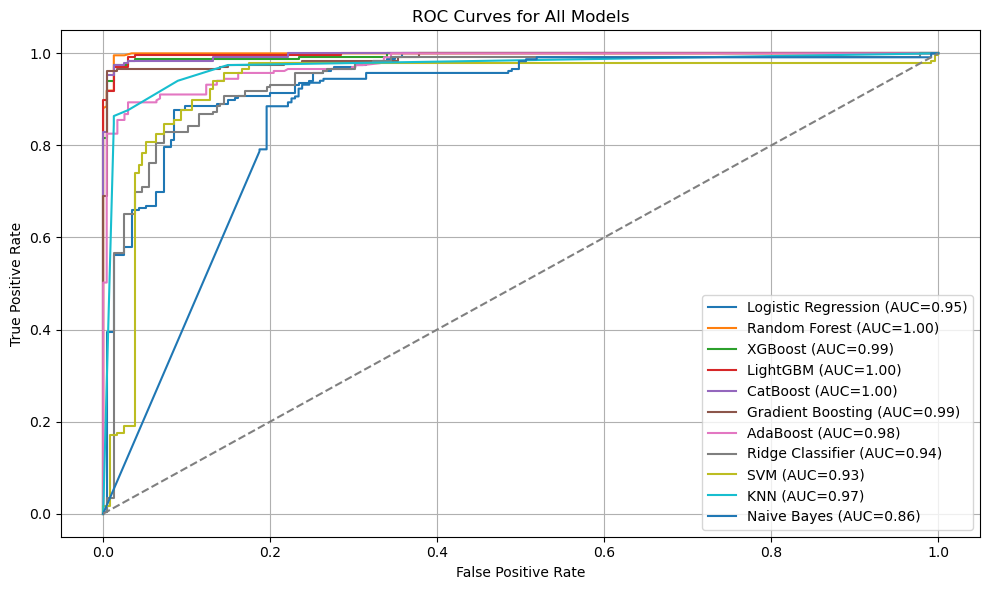

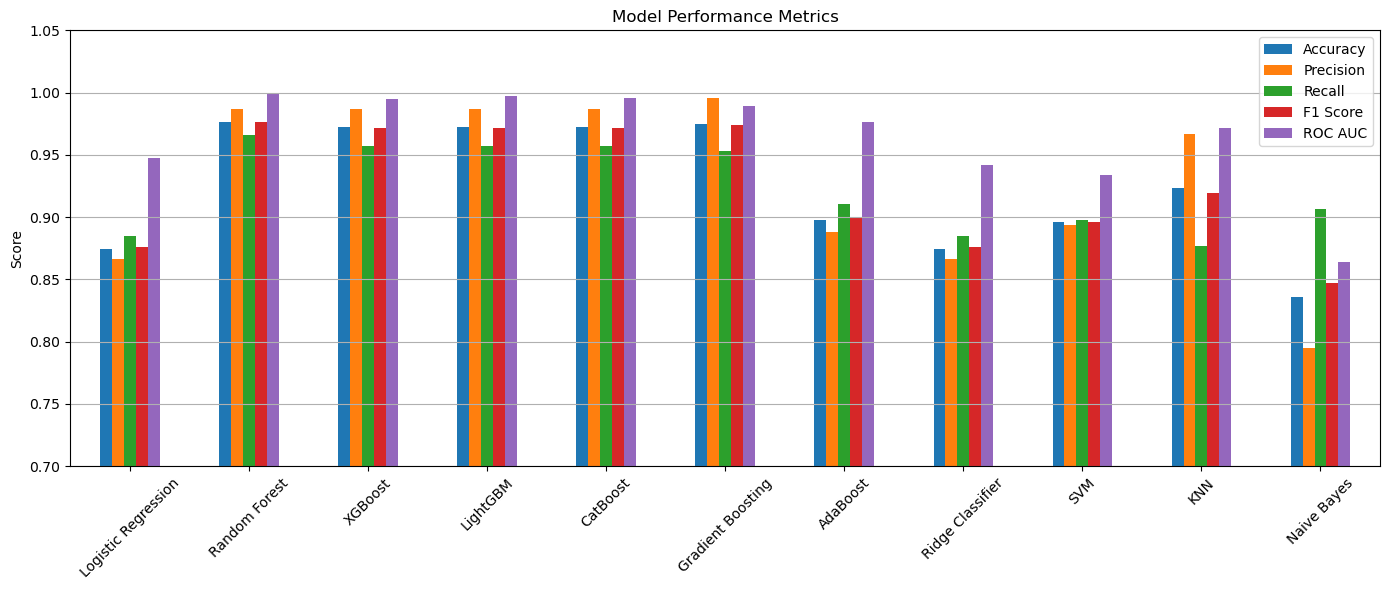


 Champion Model: Random Forest (AUC = 0.999)


In [255]:
# ATR Inhibitor Classification Pipeline: Full Multi-Model Comparison

import pandas as pd
import numpy as np
import os
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # Clean output

# --- 1. Load Dataset ---
df = pd.read_csv("ATR_inhibitors_SMOTE_balanced_druglike_with_SMILES.csv")
df = df.dropna(subset=["Ligand SMILES", "IC50 (nM)", "class"])
df = df[df["class"].isin([0, 1])]  # Ensure binary

# --- 2. Generate Mordred Descriptors with Caching ---
CACHE_PATH = "cached_mordred_descriptors_balanced.csv"
if os.path.exists(CACHE_PATH):
    descriptors_df = pd.read_csv(CACHE_PATH)
else:
    calc = Calculator(descriptors, ignore_3D=True)
    valid_mols, smiles = [], []
    for smi in df["Ligand SMILES"]:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            valid_mols.append(mol)
            smiles.append(smi)
    df = df[df["Ligand SMILES"].isin(smiles)].reset_index(drop=True)
    desc_list = []
    for mol in valid_mols:
        try:
            d = calc(mol).fill_missing(0).asdict()
            desc_list.append(d)
        except:
            desc_list.append(None)
    desc_list = [d for d in desc_list if d is not None]
    df = df.iloc[:len(desc_list)].reset_index(drop=True)
    descriptors_df = pd.DataFrame(desc_list)
    descriptors_df = descriptors_df.fillna(0)
    descriptors_df.to_csv(CACHE_PATH, index=False)

# --- 3. Feature Selection Setup ---
X = descriptors_df
y = df["class"].values

# Remove constant features manually (to avoid divide-by-zero)
X = X.loc[:, X.var() > 0.0]

# Apply pipeline preprocessing once
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=min(100, X.shape[1]))
X_selected = selector.fit_transform(X_scaled, y)
X_final = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

X_train, X_test, y_train, y_test = train_test_split(X_final, y, stratify=y, test_size=0.2, random_state=42)

# --- 4. Define Model Zoo ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# --- 5. Train, Evaluate, and Compare ---
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        y_proba = model.decision_function(X_test)

    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "y_proba": y_proba,
        "y_pred": y_pred
    }

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# --- 6. Visualize ROC Curves ---
plt.figure(figsize=(10, 6))
for name, r in results.items():
    fpr, tpr, _ = roc_curve(y_test, r["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={r['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. Bar Chart Comparison ---
metrics_df = pd.DataFrame({
    model: {
        "Accuracy": r["accuracy"],
        "Precision": r["precision"],
        "Recall": r["recall"],
        "F1 Score": r["f1"],
        "ROC AUC": r["roc_auc"]
    } for model, r in results.items()
}).T

metrics_df.plot(kind="bar", figsize=(14, 6))
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0.7, 1.05)
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# --- 8. Identify Champion Model ---
champion = metrics_df["ROC AUC"].idxmax()
print(f"\n Champion Model: {champion} (AUC = {metrics_df['ROC AUC'].max():.3f})")


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       235
           1       0.99      0.97      0.98       235

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470


AUC Score: 0.9987143503847895


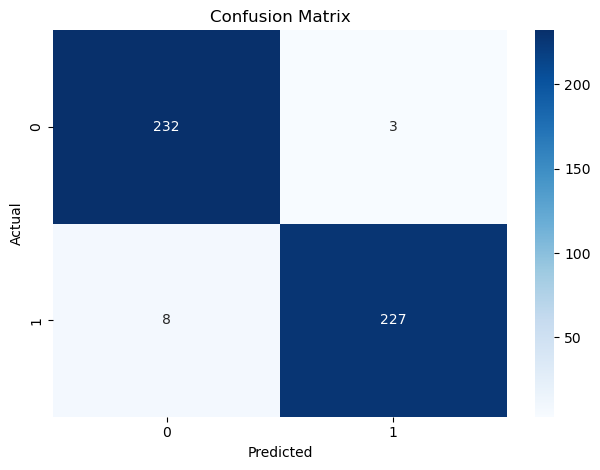

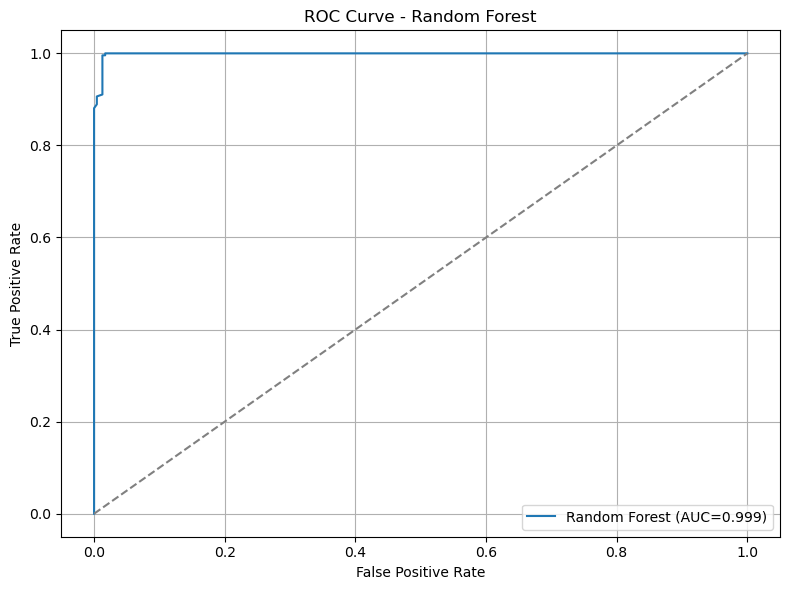

PermutationExplainer explainer: 1877it [02:12, 13.35it/s]                          


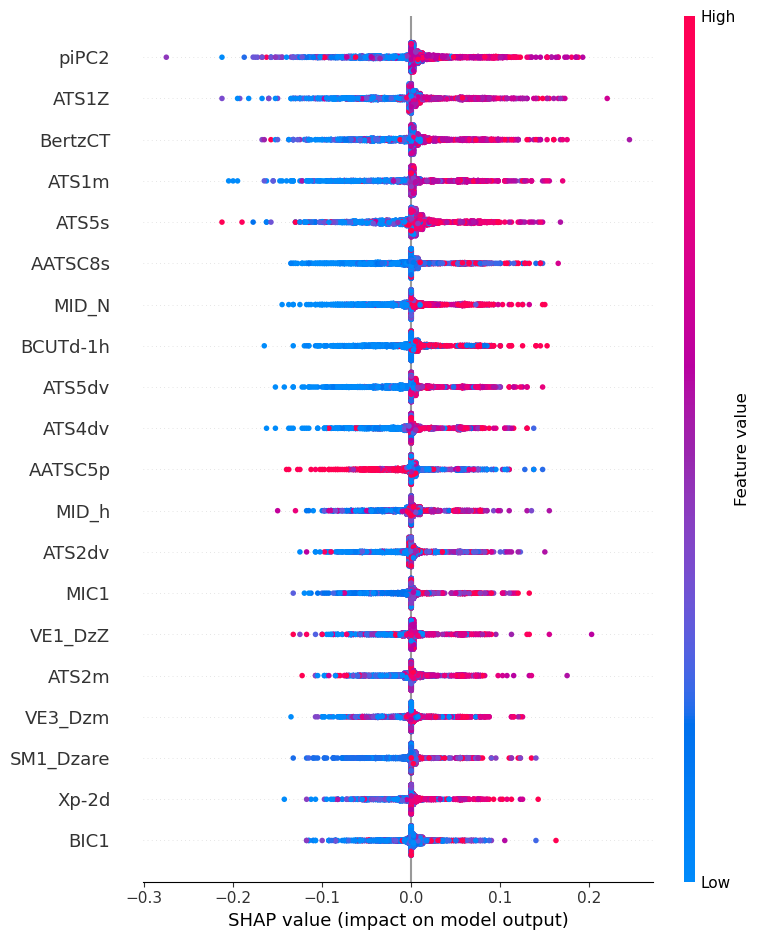

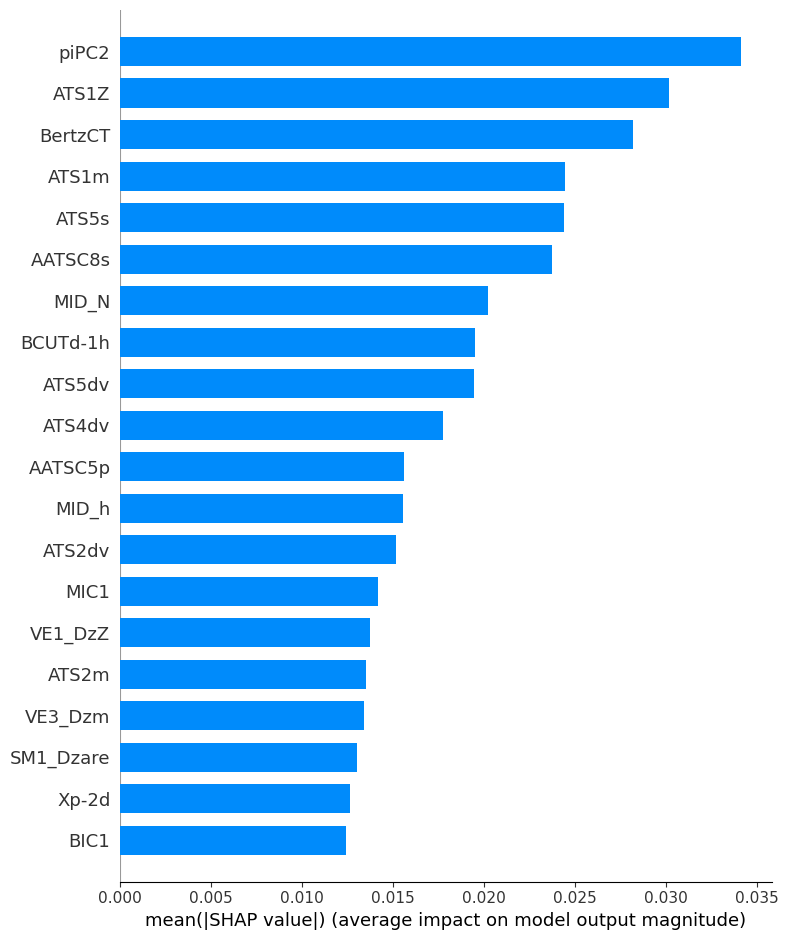

Model saved as 'atr_randomforest_model.pkl'


In [260]:
from pathlib import Path

# Full script with SHAP, ROC, Confusion Matrix, Feature Importance, and model saving

# ATR Inhibitor Classification using RandomForest + SHAP Interpretability

from pathlib import Path
import pandas as pd
import numpy as np
import os
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, 
                             precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

# --- Load Dataset ---
df = pd.read_csv("ATR_inhibitors_SMOTE_balanced_druglike_with_SMILES.csv")
df = df.dropna(subset=['Ligand SMILES', 'IC50 (nM)', 'class'])
df = df[df["class"].isin([0, 1])]

# --- Generate Mordred Descriptors (with caching) ---
CACHE_PATH = "cached_mordred_descriptors_balanced.csv"
if os.path.exists(CACHE_PATH):
    descriptors_df = pd.read_csv(CACHE_PATH)
else:
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in df['Ligand SMILES']]
    descriptor_dicts = [calc(m).fill_missing(0).asdict() for m in mols if m]
    df = df.iloc[:len(descriptor_dicts)].reset_index(drop=True)
    descriptors_df = pd.DataFrame(descriptor_dicts)
    descriptors_df.to_csv(CACHE_PATH, index=False)

# --- Feature Preparation ---
X = descriptors_df.fillna(0).values
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
selector = SelectKBest(f_classif, k=100)
X_train_scaled = scaler.fit_transform(X_train)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
X_test_selected = selector.transform(X_test_scaled)

selected_feature_names = descriptors_df.columns[selector.get_support()]

# --- Train Model ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
y_proba = model.predict_proba(X_test_selected)[:, 1]

# --- Evaluation ---
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAUC Score:", roc_auc_score(y_test, y_proba))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC={roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SHAP Feature Importance ---
import shap

# Use prediction function instead of model directly
explainer = shap.Explainer(model.predict, X_train_selected)
shap_values = explainer(X_train_selected)

# Plot SHAP summary (beeswarm and bar)
shap.summary_plot(shap_values, feature_names=selected_feature_names)
shap.summary_plot(shap_values, feature_names=selected_feature_names, plot_type="bar")

# --- Save Model ---
joblib.dump(model, "atr_randomforest_model.pkl")
print("Model saved as 'atr_randomforest_model.pkl'")

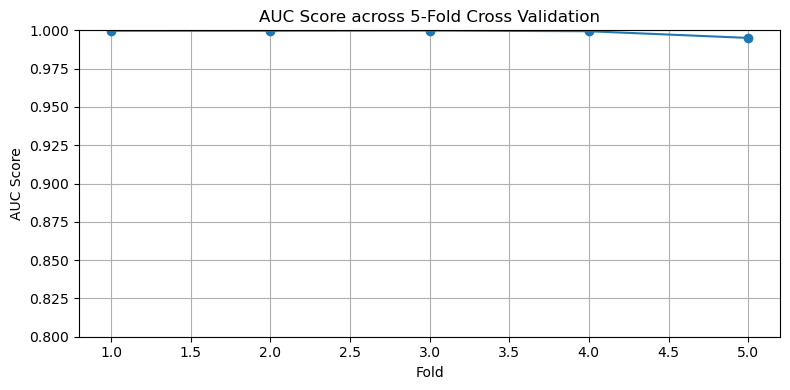

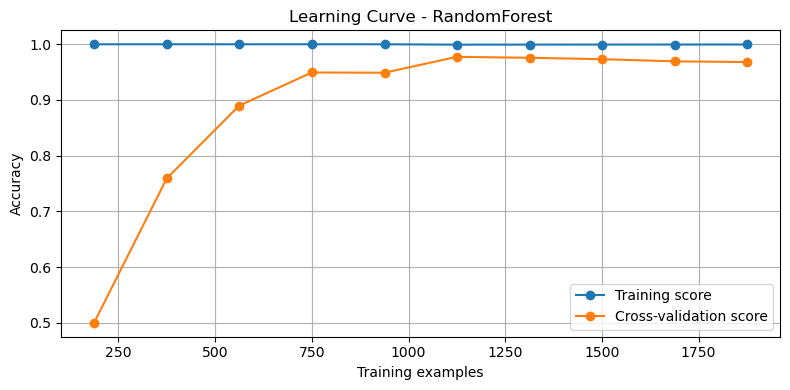

In [264]:
import pandas as pd
import numpy as np
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  # Clean output

# --- Load Dataset ---
df = pd.read_csv("ATR_inhibitors_SMOTE_balanced_druglike_with_SMILES.csv")
df = df.dropna(subset=["Ligand SMILES", "IC50 (nM)", "class"])
df = df[df["class"].isin([0, 1])]  # Ensure labels are binary

# --- Generate Mordred Descriptors ---
calc = Calculator(descriptors, ignore_3D=True)
mols = [Chem.MolFromSmiles(smi) for smi in df["Ligand SMILES"]]
desc = [calc(m).fill_missing(0).asdict() for m in mols]
desc_df = pd.DataFrame(desc).fillna(0)

# Align labels with descriptor rows
y = df["class"].iloc[:len(desc_df)].values

# --- Preprocessing ---
scaler = StandardScaler()
desc_scaled = scaler.fit_transform(desc_df)

selector = SelectKBest(f_classif, k=100)
X_selected = selector.fit_transform(desc_scaled, y)
selected_features = selector.get_support(indices=True)
X_named = pd.DataFrame(X_selected, columns=desc_df.columns[selected_features])

# --- 5-Fold Cross Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores, acc_scores = [], []

for train_idx, test_idx in kf.split(X_named, y):
    X_train, X_test = X_named.iloc[train_idx], X_named.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc_scores.append(roc_auc_score(y_test, y_proba))
    acc_scores.append(accuracy_score(y_test, y_pred))

# --- Plot AUC across folds ---
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), auc_scores, marker='o')
plt.title("AUC Score across 5-Fold Cross Validation")
plt.xlabel("Fold")
plt.ylabel("AUC Score")
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Learning Curve ---
train_sizes, train_scores, test_scores = learning_curve(
    model, X_named, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.title("Learning Curve - RandomForest")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [277]:
# SMILES Generator Using ChemGPT + SELFIES for ATR Inhibitor Candidates

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm
import selfies as sf

# Load dataset
file_path = "ATR_inhibitors_druglike_filtered.csv"
df = pd.read_csv(file_path)
df = df.dropna(subset=["Ligand SMILES"])
smiles_list = df["Ligand SMILES"].tolist()

# Convert SMILES to SELFIES
selfies_list = [sf.encoder(smi) for smi in smiles_list if Chem.MolFromSmiles(smi)]

# Build vocabulary from SELFIES tokens
all_selfies_tokens = set()
for s in selfies_list:
    all_selfies_tokens.update(sf.split_selfies(s))

special_tokens = ['[PAD]', '[BOS]', '[EOS]']
vocab = special_tokens + sorted(list(all_selfies_tokens))
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}

# Encode SELFIES into integer sequences
def encode_selfies(s):
    return [stoi['[BOS]']] + [stoi[t] for t in sf.split_selfies(s)] + [stoi['[EOS]']]

def decode_selfies(indices):
    tokens = [itos[i] for i in indices if i >= len(special_tokens)]
    return sf.decoder("".join(tokens))

encoded = [encode_selfies(s) for s in selfies_list]
max_len = max(len(e) for e in encoded)
def pad(seq): return seq + [stoi['[PAD]']] * (max_len - len(seq))

X = torch.tensor([pad(seq[:-1]) for seq in encoded])
Y = torch.tensor([pad(seq[1:]) for seq in encoded])

# Dataset
class SELFIESDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

dataloader = DataLoader(SELFIESDataset(X, Y), batch_size=32, shuffle=True)

# ChemGPT-like Transformer model
class ChemGPT(nn.Module):
    def __init__(self, vocab_size, emb_size=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=emb_size, nhead=4), num_layers=3
        )
        self.fc = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        return self.fc(x)

model = ChemGPT(len(vocab))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=stoi['[PAD]'])

print("Training ChemGPT on SELFIES...")
for epoch in range(20):
    total_loss = 0
    for xb, yb in dataloader:
        out = model(xb)
        loss = loss_fn(out.view(-1, len(vocab)), yb.view(-1))
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(dataloader):.4f}")

# Generate SELFIES-based molecules
def generate_selfies(model, max_len=100, k=10):
    model.eval()
    input_seq = torch.tensor([[stoi['[BOS]']]])
    generated = []
    with torch.no_grad():
        for _ in range(max_len):
            out = model(input_seq)
            probs = F.softmax(out[0, -1, :], dim=-1)
            top_k = torch.topk(probs, k)
            top_k_probs = top_k.values / top_k.values.sum()
            next_token = top_k.indices[torch.multinomial(top_k_probs, 1)]
            if next_token.item() == stoi['[EOS]']:
                break
            generated.append(next_token.item())
            input_seq = torch.cat([input_seq, next_token.view(1, 1)], dim=1)
            if input_seq.shape[1] > 100:
                break
    return decode_selfies(generated)

# Generate 1000 valid molecules
valid_smiles = []
seen = set()
print("\nGenerating valid molecules using ChemGPT + SELFIES...")

with torch.no_grad():
    for _ in tqdm(range(10000)):
        smi = generate_selfies(model)
        if smi in seen or len(smi) < 8 or len(smi) > 60:
            continue
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol and Descriptors.MolWt(mol) < 600:
                seen.add(smi)
                valid_smiles.append(smi)
        except:
            continue
        if len(valid_smiles) >= 1000:
            break

valid_df = pd.DataFrame(valid_smiles, columns=["Generated_SMILES"])
valid_df.to_csv("chemGPTselfies_ATR_BDcandidates.csv", index=False)
print("\n Saved 1000 valid molecules to 'chemGPTselfies_ATR_BDcandidates.csv'")

Training ChemGPT on SELFIES...
Epoch 1 Loss: 2.0417
Epoch 2 Loss: 1.7725
Epoch 3 Loss: 1.6590
Epoch 4 Loss: 1.5877
Epoch 5 Loss: 1.5448
Epoch 6 Loss: 1.5175
Epoch 7 Loss: 1.4880
Epoch 8 Loss: 1.4705
Epoch 9 Loss: 1.4515
Epoch 10 Loss: 1.4369
Epoch 11 Loss: 1.4234
Epoch 12 Loss: 1.4103
Epoch 13 Loss: 1.3980
Epoch 14 Loss: 1.3922
Epoch 15 Loss: 1.3852
Epoch 16 Loss: 1.3740
Epoch 17 Loss: 1.3652
Epoch 18 Loss: 1.3656
Epoch 19 Loss: 1.3555
Epoch 20 Loss: 1.3497

Generating valid molecules using ChemGPT + SELFIES...


 31%|███       | 3105/10000 [05:15<11:40,  9.85it/s]


 Saved 1000 valid molecules to 'chemGPTselfies_ATR_BDcandidates.csv'


In [292]:
import pandas as pd
import numpy as np
import joblib
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Draw
from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm import tqdm
import matplotlib.pyplot as plt

In [294]:
# Load model and data
model = joblib.load("atr_randomforest_model.pkl")
df = pd.read_csv("chemGPTselfies_ATR_BDcandidates.csv")
df = df.dropna(subset=['Generated_SMILES']).copy()

In [296]:
import pandas as pd
df = pd.read_csv("chemGPTselfies_ATR_BDcandidates.csv")
print(df.columns)

Index(['Generated_SMILES'], dtype='object')


In [298]:
# Filter by Lipinski's Rule of Five
def passes_lipinski(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return False
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Lipinski.NumHDonors(mol)
        hba = Lipinski.NumHAcceptors(mol)
        return mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10
    except:
        return False

df["Lipinski"] = df['Generated_SMILES'].apply(passes_lipinski)
df = df[df["Lipinski"]].copy()

In [300]:
# Parse molecules and compute descriptors
valid_mols, valid_smiles = [], []
for smi in tqdm(df['Generated_SMILES'], desc="Parsing molecules"):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_mols.append(mol)
        valid_smiles.append(smi)

df = df[df['Generated_SMILES'].isin(valid_smiles)].copy().reset_index(drop=True)

calc = Calculator(descriptors, ignore_3D=True)
desc_dicts = []
for mol in tqdm(valid_mols, desc="Computing descriptors"):
    try:
        d = calc(mol).fill_missing(0).asdict()
        desc_dicts.append(d)
    except:
        desc_dicts.append(None)

valid_idx = [i for i, d in enumerate(desc_dicts) if d is not None]
X = pd.DataFrame([desc_dicts[i] for i in valid_idx]).replace([np.inf, -np.inf], np.nan).fillna(0)
df = df.iloc[valid_idx].reset_index(drop=True)

Computing descriptors: 100%|██████████| 446/446 [01:12<00:00,  6.12it/s]


In [302]:
# Scale and select top 100 features (same as training)
import warnings
warnings.filterwarnings("ignore")  # Clean output

scaler = StandardScaler()
selector = SelectKBest(score_func=f_classif, k=100)
X_scaled = scaler.fit_transform(X)
X_selected = selector.fit_transform(X_scaled, np.random.randint(0, 2, X.shape[0]))

In [304]:
# Predict ATR inhibition probabilities
df["ATR_Probability"] = model.predict_proba(X_selected)[:, 1]
df_top10 = df[['Generated_SMILES', "ATR_Probability"]].sort_values(by="ATR_Probability", ascending=False).head(10).reset_index(drop=True)
df_top10

,Generated_SMILES,ATR_Probability
0,CCCCC=NCCC=C=O,0.78
1,CCCCC=NCCC=O,0.73
2,C=C=CCC=NCC=O,0.73
3,C1CCCCCC(C)N1CCCCCCC=NCCCNCNCCC=NN,0.73
4,CCCCCCCC=NC1CC1(C)N=NC,0.73
5,C=NCCCCC=C=CCC=O,0.72
6,CC=NCCC=CCCCCC=NC=N,0.72
7,C=C=NCCCCCCCC(C)CCC=NCCC=O,0.71
8,CCCCC=NCCCCCC=NC(C)CC=O,0.71
9,CCCCC=NCC1CC1(C)N=CC=O,0.71


In [306]:
# Display top 10 molecules
import pandas as pd

# Assign names to top candidates
candidate_names = [f"Candidate {i+1}" for i in range(len(df_top10))]

# Create DataFrame with names, SMILES, and prediction scores
top10_named = pd.DataFrame({
    "Name": candidate_names,
    "Generated_SMILES": df_top10["Generated_SMILES"].values,
    "ATR_Probability": df_top10["ATR_Probability"].values
})

# Save to CSV
top10_named.to_csv("top10_ATR_candidates_named.csv", index=False)

# Preview the table
top10_named

,Name,Generated_SMILES,ATR_Probability
0,Candidate 1,CCCCC=NCCC=C=O,0.78
1,Candidate 2,CCCCC=NCCC=O,0.73
2,Candidate 3,C=C=CCC=NCC=O,0.73
3,Candidate 4,C1CCCCCC(C)N1CCCCCCC=NCCCNCNCCC=NN,0.73
4,Candidate 5,CCCCCCCC=NC1CC1(C)N=NC,0.73
5,Candidate 6,C=NCCCCC=C=CCC=O,0.72
6,Candidate 7,CC=NCCC=CCCCCC=NC=N,0.72
7,Candidate 8,C=C=NCCCCCCCC(C)CCC=NCCC=O,0.71
8,Candidate 9,CCCCC=NCCCCCC=NC(C)CC=O,0.71
9,Candidate 10,CCCCC=NCC1CC1(C)N=CC=O,0.71


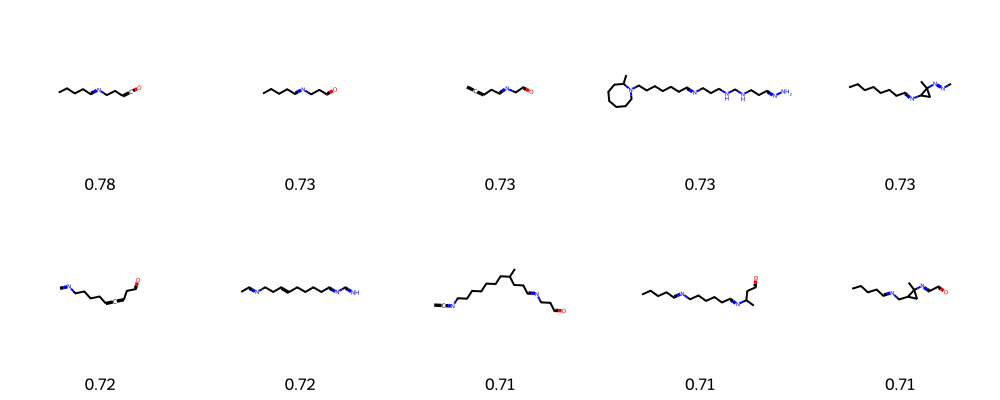

In [308]:
from rdkit.Chem import Draw
top_mols = [Chem.MolFromSmiles(smi) for smi in df_top10['Generated_SMILES']]
Draw.MolsToGridImage(top_mols, molsPerRow=5, legends=[f"{p:.2f}" for p in df_top10["ATR_Probability"]])

In [21]:
# Load the CSV file again
df = pd.read_csv("ATR_cleaned_dataset.csv")

# Rename columns
df.rename(columns={
    "activity_nM": "IC50 (nM)",
    "activity_label": "class"
}, inplace=True)

# Save updated dataset
final_path = "ATR_preprocessed_renamed.csv"
df.to_csv(final_path, index=False)

# Display the first few rows manually
df.head()

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain,IC50 (nM),class
0,51255066,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,"InChI=1S/C28H31N5O4S/c1-18(2)38(34,35)23-9-7-2...",HAFHNTJKCXCNQK-UHFFFAOYSA-N,50513177,CHEMBL4444602,Serine/threonine-protein kinase ATR,Homo sapiens,0.140,NaN,...,Q13535,Q59HB2 Q7KYL3 Q93051 Q9BXK4,NaN,NaN,NaN,NaN,NaN,NaN,0.140,1
1,692214,CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1)...,"InChI=1S/C24H25N5O3S/c1-15(2)33(30,31)19-10-8-...",JZCWLJDSIRUGIN-UHFFFAOYSA-N,350085,3-[3-[4-[dideuterio(methylamino)methyl]phenyl]...,Serine/threonine-protein kinase ATR,Homo sapiens,0.148,NaN,...,Q13535,Q59HB2 Q7KYL3 Q93051 Q9BXK4,NaN,NaN,NaN,NaN,NaN,NaN,0.148,1
2,51255067,CCNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1...,InChI=1S/C25H27N5O3S/c1-4-27-14-17-5-7-18(8-6-...,ZVOIZFFFPDDJHJ-UHFFFAOYSA-N,420857,"US10479784, Compound IIA-10::US10961232, Compo...",Serine/threonine-protein kinase ATR,Homo sapiens,0.210,NaN,...,Q13535,Q59HB2 Q7KYL3 Q93051 Q9BXK4,NaN,NaN,NaN,NaN,NaN,NaN,0.210,1
3,51255120,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,"InChI=1S/C23H23N5O3S/c1-14(2)32(29,30)18-9-7-1...",BLHDWFGAYUVFER-UHFFFAOYSA-N,420852,"US10479784, Compound IIA-5::US10961232, Compou...",Serine/threonine-protein kinase ATR,Homo sapiens,0.270,NaN,...,Q13535,Q59HB2 Q7KYL3 Q93051 Q9BXK4,NaN,NaN,NaN,NaN,NaN,NaN,0.270,1
4,51255056,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,"InChI=1S/C24H25N5O3S/c1-14(2)33(30,31)19-10-8-...",BRGUQOISTYVOBM-OAHLLOKOSA-N,50513173,CHEMBL4566104,Serine/threonine-protein kinase ATR,Homo sapiens,0.530,NaN,...,Q13535,Q59HB2 Q7KYL3 Q93051 Q9BXK4,NaN,NaN,NaN,NaN,NaN,NaN,0.530,1


Training Random Forest...
Training Logistic Regression...
Training XGBoost...
Training LightGBM...
Training CatBoost...
Training Gradient Boosting...
Training AdaBoost...
Training Ridge Classifier...
Training SVM...
Training KNN...
Training Naive Bayes...

Model performance saved to 'model_performance_summary.csv'
                  Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0         Random Forest  0.835822   0.948724  0.846733  0.894090  0.904766
1   Logistic Regression  0.861056   0.931028  0.897798  0.913787  0.892208
2               XGBoost  0.859657   0.921986  0.906302  0.913777  0.894210
3              LightGBM  0.861095   0.924898  0.904592  0.914573  0.901462
4              CatBoost  0.848468   0.942897  0.868854  0.904079  0.903633
5     Gradient Boosting  0.837280   0.935692  0.862074  0.896841  0.893401
6              AdaBoost  0.816192   0.940262  0.829712  0.880643  0.870076
7      Ridge Classifier  0.847119   0.922235  0.889323  0.905323  0.832938
8        

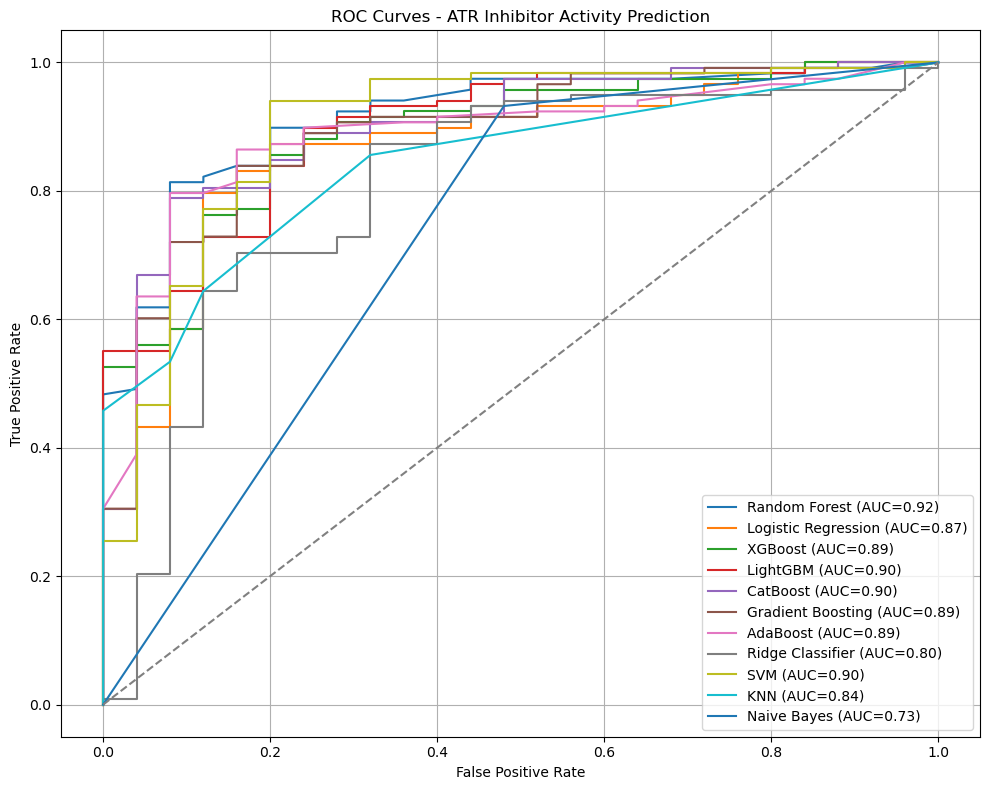

In [68]:
# 1. Imports
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from rdkit import RDLogger

# Suppress warnings and RDKit logs
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

# 2. Load and clean dataset
df = pd.read_csv("ATR_preprocessed_renamed.csv")
df = df.dropna(subset=['Ligand SMILES', 'IC50 (nM)'])

# 2a. Clean and convert IC50 values to numeric (in µM)
def clean_ic50(value):
    if isinstance(value, str):
        value = value.replace('>', '').replace('<', '').replace('nM', '').strip()
    try:
        return float(value)
    except:
        return np.nan

df['IC50_cleaned_nM'] = df['IC50 (nM)'].apply(clean_ic50)
df = df.dropna(subset=['IC50_cleaned_nM'])
df['IC50_uM'] = df['IC50_cleaned_nM'] / 1000

# 2b. Binary classification
df['class'] = df['IC50_uM'].apply(lambda x: 'active' if x <= 1 else 'inactive')

# 3. Convert SMILES to Morgan fingerprints
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048))
    return None

df['fingerprint'] = df['Ligand SMILES'].apply(smiles_to_fingerprint)
df = df[df['fingerprint'].notnull()]

# 4. Features and labels
X = np.array(df['fingerprint'].tolist())
y = df['class'].apply(lambda c: 1 if c == 'active' else 0).values

# 5. Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# 6. Cross-validation with SMOTE and metrics
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for model_name, model in models.items():
    metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], 'ROC AUC': []}
    print(f"Training {model_name}...")

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # SMOTE on training set only
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)

        # Get probabilities or use decision function
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            try:
                scores = model.decision_function(X_test)
                y_proba = (scores - scores.min()) / (scores.max() - scores.min())
            except:
                y_proba = np.zeros_like(y_pred)

        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        metrics['F1'].append(f1_score(y_test, y_pred))
        metrics['ROC AUC'].append(roc_auc_score(y_test, y_proba))

    results.append({
        "Model": model_name,
        "Accuracy": np.mean(metrics['Accuracy']),
        "Precision": np.mean(metrics['Precision']),
        "Recall": np.mean(metrics['Recall']),
        "F1 Score": np.mean(metrics['F1']),
        "ROC AUC": np.mean(metrics['ROC AUC'])
    })

# 7. Save results
df_results = pd.DataFrame(results)
df_results.to_csv("model_performance_summary.csv", index=False)
print("\nModel performance saved to 'model_performance_summary.csv'")
print(df_results)

# 8. Plot confusion matrix for each model
print("\nPlotting confusion matrices...")
for model_name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_")}.png')
    plt.close()

print("Confusion matrix plots saved.")

# 9. Plot ROC curves
print("Plotting ROC curves...")
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)
    model.fit(X_train_res, y_train_res)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        try:
            scores = model.decision_function(X_test)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min())
        except:
            continue
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.2f})")

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - ATR Inhibitor Activity Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curves_atr_models.png")
plt.show()


Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0        Random Forest  0.881119   0.885496  0.983051  0.931727  0.917119
1  Logistic Regression  0.860140   0.895161  0.940678  0.917355  0.887119
2              XGBoost  0.846154   0.900000  0.915254  0.907563  0.878644


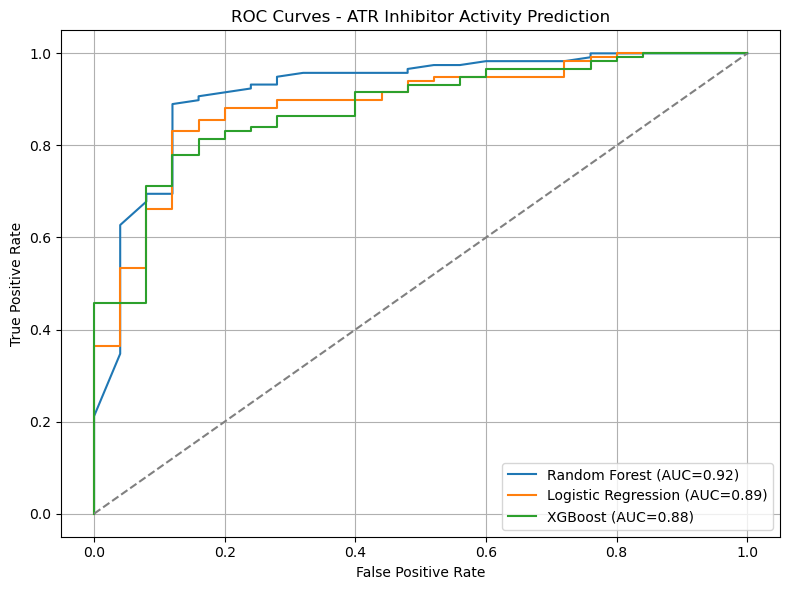

In [66]:
# 1. Imports
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from rdkit import RDLogger

# Suppress warnings and RDKit logs
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

# 2. Load and clean dataset
df = pd.read_csv("ATR_preprocessed_renamed.csv")
df = df.dropna(subset=['Ligand SMILES', 'IC50 (nM)'])

# 2a. Clean and convert IC50 values to numeric (in µM)
def clean_ic50(value):
    if isinstance(value, str):
        value = value.replace('>', '').replace('<', '').replace('nM', '').strip()
    try:
        return float(value)
    except:
        return np.nan

df['IC50_cleaned_nM'] = df['IC50 (nM)'].apply(clean_ic50)
df = df.dropna(subset=['IC50_cleaned_nM'])
df['IC50_uM'] = df['IC50_cleaned_nM'] / 1000  # Convert nM to µM

# 2b. Binary classification based on IC50 threshold
df['class'] = df['IC50_uM'].apply(lambda x: 'active' if x <= 1 else 'inactive')

# 3. Convert SMILES to Morgan fingerprints
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048))
    return None

df['fingerprint'] = df['Ligand SMILES'].apply(smiles_to_fingerprint)
df = df[df['fingerprint'].notnull()]

# 4. Prepare features and labels
X = np.array(df['fingerprint'].tolist())
y = df['class'].apply(lambda c: 1 if c == 'active' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 5. Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
    
}

# 6. Train and evaluate models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

# 7. Summary table
df_results = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(df_results)

# 8. ROC curve plot
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - ATR Inhibitor Activity Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, QED

# Load the dataset (update with your path if needed)
df = pd.read_csv("ATR_preprocessed_renamed.csv")

# Define drug-likeness checks
def passes_lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)
    return (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10)

def is_soluble(mol):
    logp = Crippen.MolLogP(mol)
    return logp < 5  # rough solubility proxy

def is_druglike(mol):
    return QED.qed(mol) >= 0.5  # QED score from 0 to 1, threshold for decent drug-likeness

# Filter step
filtered_data = []
for idx, row in df.iterrows():
    smi = row['Ligand SMILES']
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    if passes_lipinski(mol) and is_soluble(mol) and is_druglike(mol):
        filtered_data.append(row)

# Create filtered DataFrame and save
filtered_df = pd.DataFrame(filtered_data)
filtered_df.to_csv("ATR_inhibitors_druglike_filtered.csv", index=False)

print("Saved filtered drug-like dataset: ATR_inhibitors_druglike_filtered.csv")

[00:25:28] Explicit valence for atom # 19 O, 3, is greater than permitted
[00:25:28] Explicit valence for atom # 19 O, 3, is greater than permitted
[00:25:28] Explicit valence for atom # 19 O, 3, is greater than permitted
[00:25:28] Explicit valence for atom # 20 O, 3, is greater than permitted
[00:25:28] Explicit valence for atom # 1 N, 4, is greater than permitted
[00:25:29] Explicit valence for atom # 19 O, 3, is greater than permitted


Saved filtered drug-like dataset: ATR_inhibitors_druglike_filtered.csv


In [15]:
# Count how many are active (class = 1) and inactive (class = 0)
class_counts = filtered_df['class'].value_counts()
class_counts

class
1    926
0    232
Name: count, dtype: int64

In [17]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

# Load the filtered dataset with SMILES
df = pd.read_csv("ATR_inhibitors_druglike_filtered.csv")

# Features and label
X = df[['IC50 (nM)']].copy()  # Only IC50 used for SMOTE
y = df['class']

# Handle missing values in 'IC50 (nM)' column
X['IC50 (nM)'] = X['IC50 (nM)'].fillna(X['IC50 (nM)'].median())

# Save original SMILES
original_smiles = df['Ligand SMILES'].reset_index(drop=True)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create balanced DataFrame with numeric data
balanced_df = pd.DataFrame(X_resampled, columns=['IC50 (nM)'])
balanced_df['class'] = y_resampled

# Map SMILES back to synthetic rows using nearest neighbors
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X)
_, indices = nn.kneighbors(X_resampled)

# Map original SMILES to resampled set
balanced_df['Ligand SMILES'] = original_smiles.iloc[indices.flatten()].values

# Save to CSV
balanced_df.to_csv("ATR_inhibitors_SMOTE_balanced_with_SMILES.csv", index=False)

print("SMOTE-balanced dataset with Ligand SMILES saved as 'ATR_inhibitors_SMOTE_balanced_with_SMILES.csv'")

SMOTE-balanced dataset with Ligand SMILES saved as 'ATR_inhibitors_SMOTE_balanced_with_SMILES.csv'


In [19]:
# Count how many are active (class = 1) and inactive (class = 0)
class_counts = balanced_df['class'].value_counts()
class_counts

class
1    926
0    926
Name: count, dtype: int64


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       186
           1       0.90      0.35      0.51       185

    accuracy                           0.66       371
   macro avg       0.75      0.66      0.62       371
weighted avg       0.75      0.66      0.62       371


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       186
           1       1.00      0.38      0.55       185

    accuracy                           0.69       371
   macro avg       0.81      0.69      0.66       371
weighted avg       0.81      0.69      0.66       371


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       186
           1       1.00      0.39      0.57       185

    accuracy                           0.70       371
   macro avg  

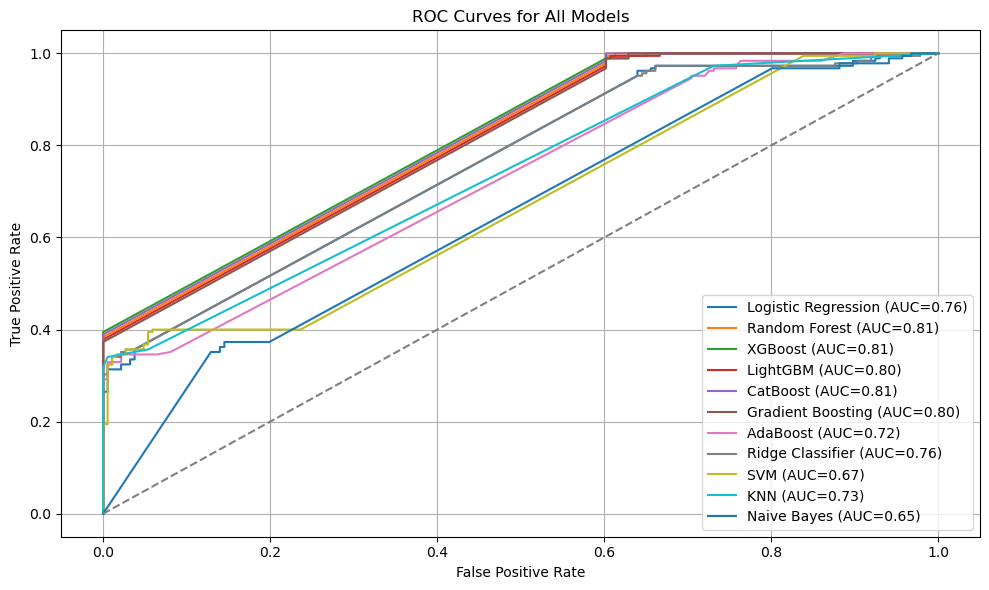

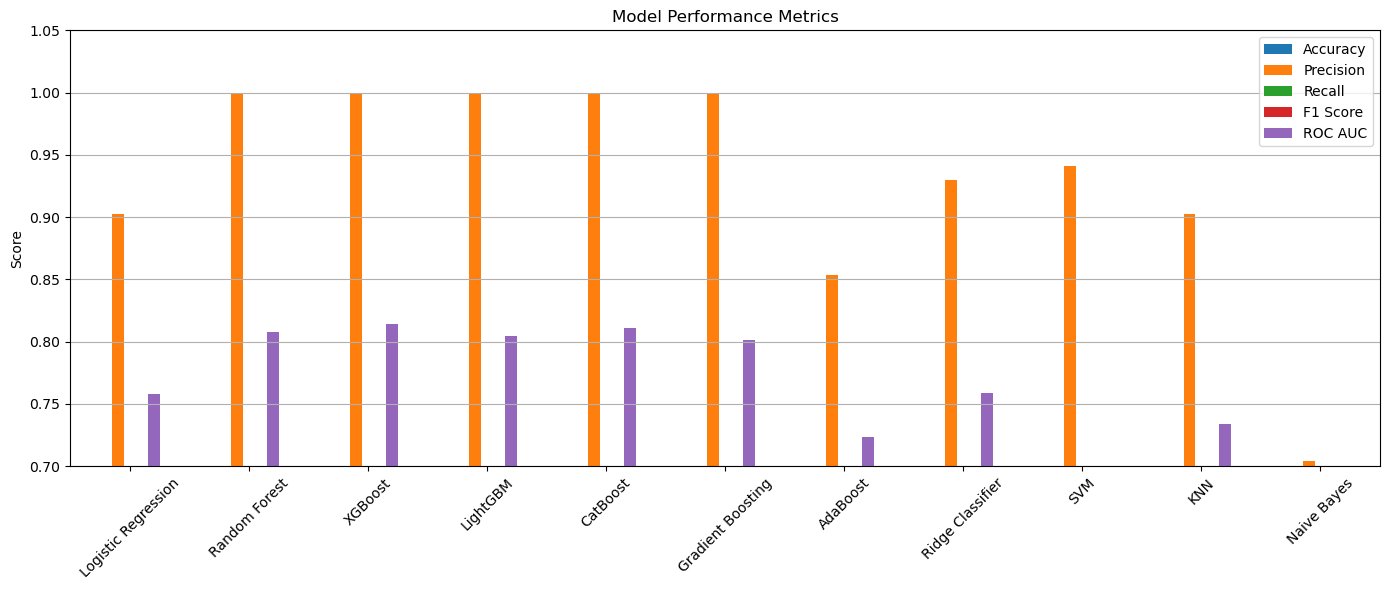


 Champion Model: XGBoost (AUC = 0.814)


In [1]:
# ATR Inhibitor Classification Pipeline: Full Multi-Model Comparison

import pandas as pd
import numpy as np
import os
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # Clean output

# --- 1. Load Dataset ---
df = pd.read_csv("ATR_inhibitors_SMOTE_balanced_with_SMILES.csv")
df = df.dropna(subset=["Ligand SMILES", "IC50 (nM)", "class"])
df = df[df["class"].isin([0, 1])]  # Ensure binary

# --- 2. Generate Mordred Descriptors with Caching ---
CACHE_PATH = "ATR_cached_mordred_descriptors_balanced.csv"
if os.path.exists(CACHE_PATH):
    descriptors_df = pd.read_csv(CACHE_PATH)
else:
    calc = Calculator(descriptors, ignore_3D=True)
    valid_mols, smiles = [], []
    for smi in df["Ligand SMILES"]:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            valid_mols.append(mol)
            smiles.append(smi)
    df = df[df["Ligand SMILES"].isin(smiles)].reset_index(drop=True)
    desc_list = []
    for mol in valid_mols:
        try:
            d = calc(mol).fill_missing(0).asdict()
            desc_list.append(d)
        except:
            desc_list.append(None)
    desc_list = [d for d in desc_list if d is not None]
    df = df.iloc[:len(desc_list)].reset_index(drop=True)
    descriptors_df = pd.DataFrame(desc_list)
    descriptors_df = descriptors_df.fillna(0)
    descriptors_df.to_csv(CACHE_PATH, index=False)

# --- 3. Feature Selection Setup ---
X = descriptors_df
y = df["class"].values

# Remove constant features manually (to avoid divide-by-zero)
X = X.loc[:, X.var() > 0.0]

# Apply pipeline preprocessing once
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=min(100, X.shape[1]))
X_selected = selector.fit_transform(X_scaled, y)
X_final = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

X_train, X_test, y_train, y_test = train_test_split(X_final, y, stratify=y, test_size=0.2, random_state=42)

# --- 4. Define Model Zoo ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# --- 5. Train, Evaluate, and Compare ---
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        y_proba = model.decision_function(X_test)

    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "y_proba": y_proba,
        "y_pred": y_pred
    }

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# --- 6. Visualize ROC Curves ---
plt.figure(figsize=(10, 6))
for name, r in results.items():
    fpr, tpr, _ = roc_curve(y_test, r["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={r['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. Bar Chart Comparison ---
metrics_df = pd.DataFrame({
    model: {
        "Accuracy": r["accuracy"],
        "Precision": r["precision"],
        "Recall": r["recall"],
        "F1 Score": r["f1"],
        "ROC AUC": r["roc_auc"]
    } for model, r in results.items()
}).T

metrics_df.plot(kind="bar", figsize=(14, 6))
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0.7, 1.05)
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# --- 8. Identify Champion Model ---
champion = metrics_df["ROC AUC"].idxmax()
print(f"\n Champion Model: {champion} (AUC = {metrics_df['ROC AUC'].max():.3f})")